**Step 1 | Import Necessary Libraries**  (TensorFlow and Keras to handle the image data)

In [1]:
import cv2
import numpy as np
import urllib.request
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D
from keras.layers import Dropout, Flatten, BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import load_model



**Step 2 | Data Preparation and Exploration**

Download the CIFAR-10 dataset from Keras library:

In [2]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 13s 0us/step


Split original training data to training and validation sets

In [3]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=0)

Printing out the dimensions of our training, validation, and test datasets

In [4]:
print('Train Images Shape:      ', X_train.shape)
print('Train Labels Shape:      ', y_train.shape)

print('\nValidation Images Shape: ', X_valid.shape)
print('Validation Labels Shape: ', y_valid.shape)

print('\nTest Images Shape:       ', X_test.shape)
print('Test Labels Shape:       ', y_test.shape)

Train Images Shape:       (45000, 32, 32, 3)
Train Labels Shape:       (45000, 1)

Validation Images Shape:  (5000, 32, 32, 3)
Validation Labels Shape:  (5000, 1)

Test Images Shape:        (10000, 32, 32, 3)
Test Labels Shape:        (10000, 1)


An overview of the CIFAR-10 dataset

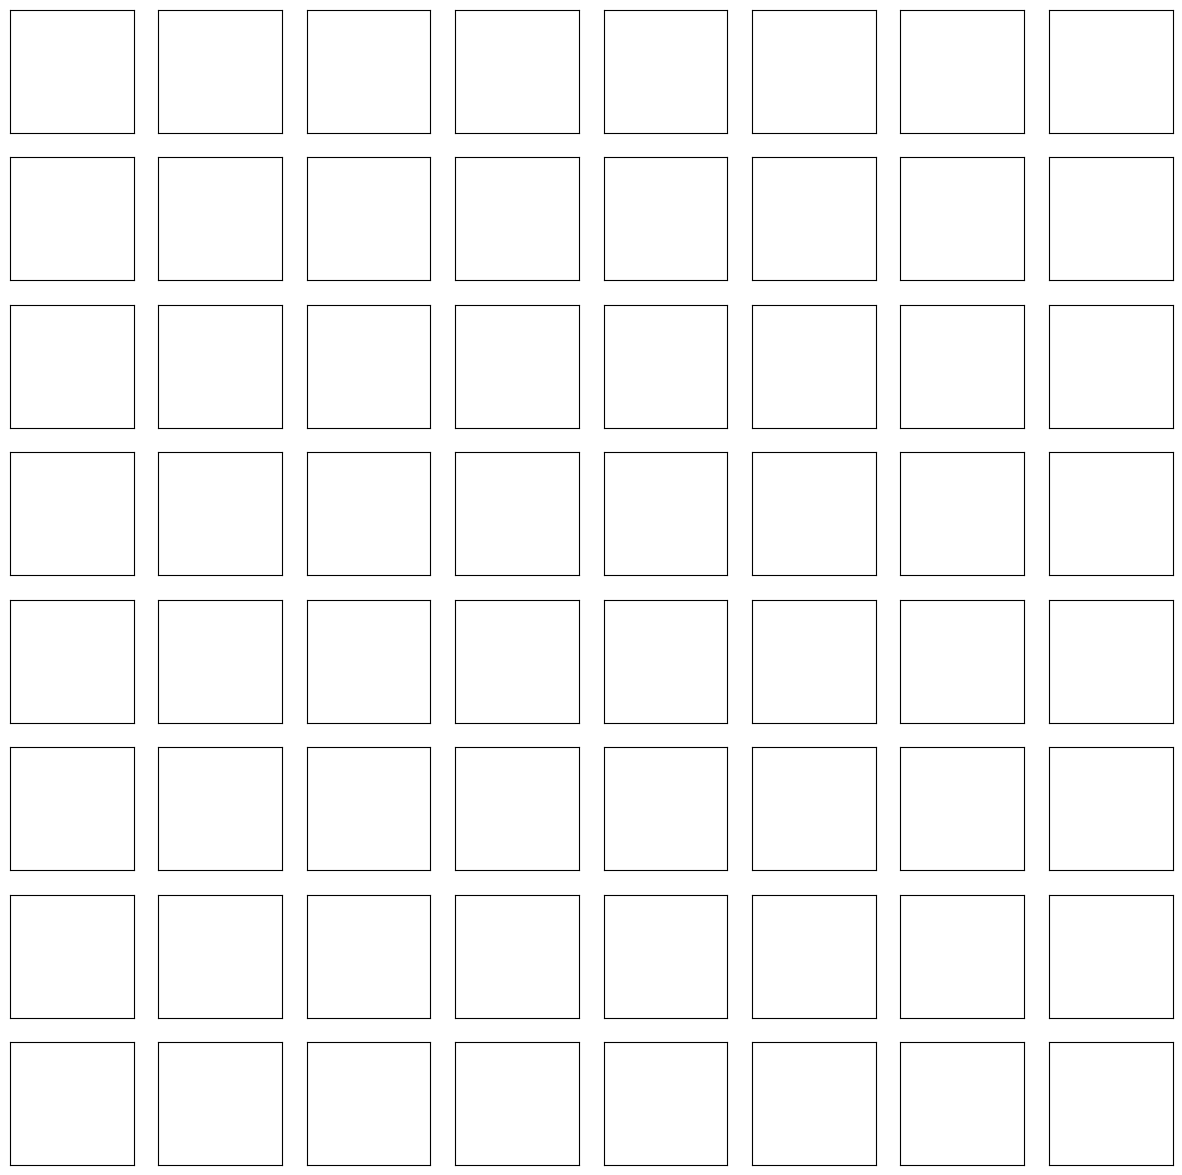

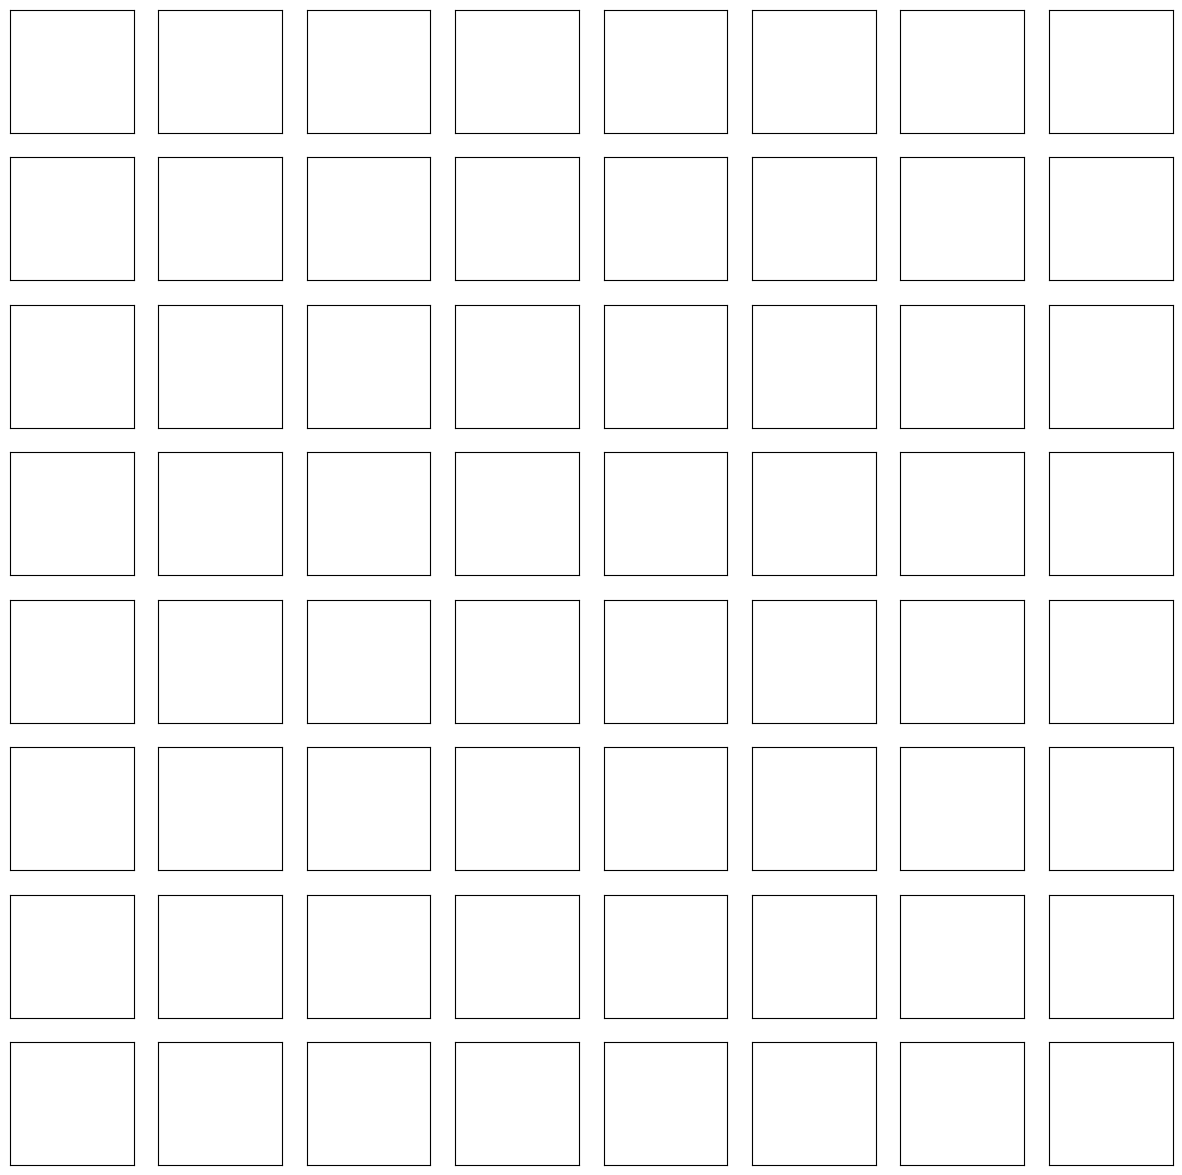

In [5]:
# CIFAR-10 classes
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Create a new figure
plt.figure(figsize=(15,15))

# Loop over the first 25 images
for i in range(64):
    # Create a subplot for each image
    plt.subplot(8, 8, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
# CIFAR-10 classes
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Create a new figure
plt.figure(figsize=(15,15))

# Loop over the first 25 images
for i in range(64):
    # Create a subplot for each image
    plt.subplot(8, 8, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)


**Step 3 | Data Preprocessing**

Normalization of Image Data (convert the pixel values data type to float32 type, and then normalizes them by subtracting the mean and dividing by the standard deviation of the training set)

In [6]:
# Convert pixel values data type to float32
X_train = X_train.astype('float32')
X_test  = X_test.astype('float32')
X_valid = X_valid.astype('float32')

# Calculate the mean and standard deviation of the training images
mean = np.mean(X_train)
std  = np.std(X_train)

# Normalize the data
# The tiny value 1e-7 is added to prevent division by zero
X_train = (X_train-mean)/(std+1e-7)
X_test  = (X_test-mean) /(std+1e-7)
X_valid = (X_valid-mean)/(std+1e-7)

One-Hot Encoding of Labels convert the class labels to one-hot vectors to transform the categorical labels into a format suitable

In [7]:
y_train = to_categorical(y_train, 10)
y_valid = to_categorical(y_valid, 10)
y_test  = to_categorical(y_test, 10)

**Data Augmentation** expand the size of the training set by creating modified versions of images in the dataset.
Data augmentation techniques such as rotations, shifts, flips, shearing, and intensity changes introduce small variations to the existing images, creating a broader set of training samples to learn from.

In [8]:
# Data augmentation
data_generator = ImageDataGenerator(
    # Rotate images randomly by up to 15 degrees
    rotation_range=15,

    # Shift images horizontally by up to 12% of their width
    width_shift_range=0.12,

    # Shift images vertically by up to 12% of their height
    height_shift_range=0.12,

    # Randomly flip images horizontally
    horizontal_flip=True,

    # Zoom images in by up to 10%
    zoom_range=0.1,

    # Change brightness by up to 10%
    brightness_range=[0.9,1.1],

    # Shear intensity (shear angle in counter-clockwise direction in degrees)
    shear_range=10,

    # Channel shift intensity
    channel_shift_range=0.1,
)

**Step 4 | Define CNN Model Architecture**

**A brief explanation of the architecture:**

**1-**The network begins with a pair of Conv2D layers, each with 32 filters of size 3x3. This is followed by a Batch Normalization layer which accelerates training and provides some level of regularization, helping to prevent overfitting.

**2-** The pairs of Conv2D layers are followed by a MaxPooling2D layer, which reduces the spatial dimensions (height and width), effectively providing a form of translation invariance and reducing computational complexity. This is followed by a Dropout layer that randomly sets a fraction (0.2 for the first dropout layer) of the input units to 0 at each update during training, helping to prevent overfitting.

**3-** This pattern of two Conv2D layers, followed by a Batch Normalization layer, a MaxPooling2D layer, and a Dropout layer, repeats three more times. The number of filters in the Conv2D layers doubles with each repetition, starting from 32 and going up to 64, 128, and then 256. This increasing pattern helps the network to learn more complex features at each level. The dropout rate also increases at each step, from 0.2 to 0.5.

**4-** After the convolutional and pooling layers, a Flatten layer is used to convert the 2D outputs of the preceding layer into a 1D vector.

**5-** Finally, a Dense (or fully connected) layer is used for classification. It has 10 units, each representing one of the 10 classes of the CIFAR-10 dataset, and a softmax activation function is used to convert the outputs to probability scores for each class



In [9]:
# Initialize a sequential model
model = Sequential()

# Set the weight decay value for L2 regularization
weight_decay = 0.0001

# Add the first convolutional layer with 32 filters of size 3x3
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay),
                 input_shape=X_train.shape[1:]))
# Add batch normalization layer
model.add(BatchNormalization())

# Add the second convolutional layer similar to the first
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(BatchNormalization())
# Add the first max pooling layer with pool size of 2x2
model.add(MaxPooling2D(pool_size=(2, 2)))
# Add dropout layer with 0.2 dropout rate
model.add(Dropout(rate=0.2))

# Add the third and fourth convolutional layers with 64 filters
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(BatchNormalization())

# Add the second max pooling layer and increase dropout rate to 0.3
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.3))
# Add the fifth and sixth convolutional layers with 128 filters
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(BatchNormalization())

# Add the third max pooling layer and increase dropout rate to 0.4
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.4))

# Add the seventh and eighth convolutional layers with 256 filters
model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(BatchNormalization())
model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(BatchNormalization())
# Add the fourth max pooling layer and increase dropout rate to 0.5
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.5))

# Flatten the tensor output from the previous layer
model.add(Flatten())

# Add a fully connected layer with softmax activation function for outputting class probabilities
model.add(Dense(10, activation='softmax'))

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 32, 32, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Bat  (None, 32, 32, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                        

**Step 5 | Training the CNN Model**

The training uses a batch size of 64 and will run for a maximum of 100 epochs or until the early stopping condition is met. During the training, the model's performance is evaluated on the validation data after each epoch.

**The ReduceLROnPlateau** callback is used to reduce the learning rate by half (factor=0.5) whenever the validation loss does not improve for 10 consecutive epochs. This helps to adjust the learning rate dynamically, allowing the model to get closer to the global minimum of the loss function when progress has plateaued. This strategy can improve the convergence of the training process.



**The EarlyStopping** callback is employed to monitor the validation loss and halt the training process when there hasn't been any improvement for a certain number of epochs, ensuring that the model doesn't waste computational resources and time. Furthermore, this callback restores the best weights from the training process, ensuring we conclude with the optimal model configuration from the epochs.

In [11]:
 #Set the batch size for the training
batch_size = 64

# Set the maximum number of epochs for the training
epochs = 100

# Define the optimizer (Adam)
optimizer = Adam(learning_rate=0.0005)

# Compile the model with the defined optimizer, loss function, and metrics
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
# Add ReduceLROnPlateau callback
# Here, the learning rate will be reduced by half (factor=0.5) if no improvement in validation loss is observed for 10 epochs
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.00001)

# Add EarlyStopping callback
# Here, training will be stopped if no improvement in validation loss is observed for 40 epochs.
# The `restore_best_weights` parameter ensures that the model weights are reset to the values from the epoch
# with the best value of the monitored quantity (in this case, 'val_loss').
early_stopping = EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True, verbose=1)
# Fit the model on the training data, using the defined batch size and number of epochs
# The validation data is used to evaluate the model's performance during training
# The callbacks implemented are learning rate reduction when a plateau is reached in validation loss and
# stopping training early if no improvement is observed
model.fit(data_generator.flow(X_train, y_train, batch_size=batch_size),
          epochs=epochs,
          validation_data=(X_valid, y_valid),
          callbacks=[reduce_lr, early_stopping],
          verbose=2)


Epoch 1/100
704/704 - 70s - loss: 2.3118 - accuracy: 0.3459 - val_loss: 1.7809 - val_accuracy: 0.4456 - lr: 5.0000e-04 - 70s/epoch - 99ms/step
Epoch 2/100
704/704 - 56s - loss: 1.7191 - accuracy: 0.4733 - val_loss: 1.9492 - val_accuracy: 0.5094 - lr: 5.0000e-04 - 56s/epoch - 79ms/step
Epoch 3/100
704/704 - 57s - loss: 1.4993 - accuracy: 0.5386 - val_loss: 1.2994 - val_accuracy: 0.5892 - lr: 5.0000e-04 - 57s/epoch - 81ms/step
Epoch 4/100
704/704 - 56s - loss: 1.3198 - accuracy: 0.5855 - val_loss: 1.2750 - val_accuracy: 0.6198 - lr: 5.0000e-04 - 56s/epoch - 80ms/step
Epoch 5/100
704/704 - 56s - loss: 1.2123 - accuracy: 0.6169 - val_loss: 1.0366 - val_accuracy: 0.6830 - lr: 5.0000e-04 - 56s/epoch - 80ms/step
Epoch 6/100
704/704 - 57s - loss: 1.1293 - accuracy: 0.6476 - val_loss: 1.0838 - val_accuracy: 0.6784 - lr: 5.0000e-04 - 57s/epoch - 81ms/step
Epoch 7/100
704/704 - 57s - loss: 1.0581 - accuracy: 0.6728 - val_loss: 0.9762 - val_accuracy: 0.7048 - lr: 5.0000e-04 - 57s/epoch - 80ms/step

**Step 6 | Visualizing the Learning Curves**

In [ ]:
plt.figure(figsize=(15,6))

# Plotting the training and validation loss
plt.subplot(1, 2, 1)
plt.plot(model.history.history['loss'], label='Train Loss', color='#8502d1')
plt.plot(model.history.history['val_loss'], label='Validation Loss', color='darkorange')
plt.legend()
plt.title('Loss Evolution')

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(model.history.history['accuracy'], label='Train Accuracy', color='#8502d1')
plt.plot(model.history.history['val_accuracy'], label='Validation Accuracy', color='darkorange')
plt.legend()
plt.title('Accuracy Evolution')

plt.show()

**Step 7 | Evaluating the Optimal Model on Test Data**

In [14]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)

print('\nTest Accuracy:', test_acc)
print('Test Loss:    ', test_loss)

313/313 [==============================] - 2s 7ms/step - loss: 0.5042 - accuracy: 0.8914

Test Accuracy: 0.8913999795913696
Test Loss:     0.5042402148246765


In [17]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)

print('\nTest Accuracy:', test_acc)
print('Test Loss:    ', test_loss)

313/313 [==============================] - 1s 4ms/step - loss: 0.5042 - accuracy: 0.8914

Test Accuracy: 0.8913999795913696
Test Loss:     0.5042402148246765
